In [1]:
import numpy as np
import pandas as pd
#!{sys.executable} -m pip install --user netCDF
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import torch
import matplotlib.animation as animation
import torch.nn.functional as F
import random
import os
from tqdm.notebook import tqdm
#import shutil
#shutil.rmtree('/global/cscratch1/sd/rwang2/Data/Subsample_128')

### Augmented test set for Scale Equivariance

In [5]:
nc = Dataset('/project/projectdirs/dasrepo/mustafa/datasets/Rayleigh_Benard/result_rb_2d__Ra_2.5e8__Pr_0.71__maxMach_0.1__t_D_max_diffusive_scaling__0.4.nc')
#/project/projectdirs/dasrepo/mustafa/data/result_rb_2d__Ra_2.5e8__Pr_0.71__maxMach_0.1__t_D_max_diffusive_scaling__0.4.nc
raw_ux = nc['u_x'][10500:11500]
raw_uy = nc['u_y'][10500:11500]
#raw_pres = nc['press_diff'][10000:11500]
#raw_temp = nc['temp_diff'][10000:11500]
TB_data = []
for i in range(raw_ux.shape[0]):
    x = np.array([raw_ux[i].filled()[:,k*256:(k+1)*256] for k in range(7)])
    y = np.array([raw_uy[i].filled()[:,k*256:(k+1)*256] for k in range(7)])
    temp = np.array([x,y])
    TB_data.append(temp) 
Data = np.array(TB_data).transpose(2,0,1,3,4)
std = 4522.7046
avg = 1.0424337
Data = (Data - avg)/std
data_64 = torch.from_numpy(Data[:,:,:,::4,::4]).transpose(1,2)
data_128 = F.interpolate(torch.from_numpy(Data[:,:,:,::2,::2]).transpose(1,2), scale_factor = (4, 1, 1), mode="trilinear")/2#.cpu().data.numpy()

/global/homes/r/roseyu/.conda/envs/myenv/lib/python3.6/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [18]:
idx = torch.from_numpy(np.array(range(0,256,2)))
seqs = []
for j in range(0, 1510-100):
    for i in range(Data.shape[0]):
        torch.save(torch.FloatTensor(Data[i, j : j + 100][:,:,idx][:,:,:,idx]), "/global/cscratch1/sd/roseyu/Eliza/TF-net/Data/data_128/sample_" + str(j*7+i) + ".pt")

In [3]:
out = data_64

In [4]:
k = 0
for j in range(0, out.shape[2]-500):
    for i in range(7): 
        factor = 2.5#random.sample([0.5, 2], 1)[0]
        img = out[i,:,j:j+50].unsqueeze(0)
        #print(img.max(), img.min())
        scale_img = F.interpolate(img, scale_factor = (factor**2, factor, factor), mode="trilinear", align_corners = True).squeeze(0).transpose(0,1)#/factor
        #print((img.max() - img.min())/(scale_img.max() - scale_img.min()))
        scale_img = scale_img*(img.max() - img.min())/(scale_img.max() - scale_img.min())/factor
        #
        torch.save(scale_img[:100], "/global/cscratch1/sd/roseyu/aug_test/S250/sample_" + str(k+7000) + ".pt")
        k+=1        
        if k == 10:
            break           
    if k == 10:
        break

In [19]:
factor

1

In [29]:
k = 0
for j in range(0, out.shape[1]-100):
    for i in range(7): 
        img = out[i,j:j+100]
        torch.save(img, "/global/cscratch1/sd/roseyu/scale2_64/sample_" + str(k+7000+750) + ".pt")
        k+=1
        if k == 250:
            break
    if k == 250:
        break

### Data For CNN

In [2]:
nc = Dataset('/project/projectdirs/dasrepo/mustafa/datasets/Rayleigh_Benard/result_rb_2d__Ra_2.5e8__Pr_0.71__maxMach_0.1__t_D_max_diffusive_scaling__0.4.nc')
#/project/projectdirs/dasrepo/mustafa/data/result_rb_2d__Ra_2.5e8__Pr_0.71__maxMach_0.1__t_D_max_diffusive_scaling__0.4.nc
raw_ux = nc['u_x'][9990:11500]
raw_uy = nc['u_y'][9990:11500]
#raw_pres = nc['press_diff'][10000:11500]
#raw_temp = nc['temp_diff'][10000:11500]
TB_data = []
for i in range(raw_ux.shape[0]):
    x = np.array([raw_ux[i].filled()[:,k*256:(k+1)*256] for k in range(7)])
    y = np.array([raw_uy[i].filled()[:,k*256:(k+1)*256] for k in range(7)])
    temp = np.array([x,y])
    TB_data.append(temp) 
#num_subregions * time * channels * w * h
Data = np.array(TB_data).transpose(2,0,1,3,4)
std = 4522.7046
avg = 1.0424337
Data = (Data - avg)/std
#np.save("/global/cscratch1/sd/roseyu/Eliza/Data/TF_data.npy", Data)
#std: 4522.7046
#avg: 1.0424337

In [4]:
# no crop
data = np.array([[raw_ux[i].filled(), raw_uy[i].filled()] for i in range(raw_ux.shape[0])])
data = (data - avg)/std
idx = torch.from_numpy(np.array(range(0,256,4)))
idy = torch.from_numpy(np.array(range(0,1792,4)))
seqs = []
for j in range(0, 1510-100):
    torch.save(torch.FloatTensor(data[j : j + 100][:,:,idx][:,:,:,idy]), "/global/cscratch1/sd/roseyu/Eliza/TF-net/Data/imgs_64/sample_" + str(j) + ".pt")

In [7]:
idx = torch.from_numpy(np.array(range(0,256,4)))
seqs = []
for j in range(0, 1510-100):
    for i in range(Data.shape[0]):
        torch.save(torch.FloatTensor(Data[i, j : j + 100][:,:,idx][:,:,:,idx]), "/global/cscratch1/sd/roseyu/Eliza/TF-net/Data/data_64/sample_" + str(j*7+i) + ".pt")

### Test Data for Rot

In [2]:
import torchvision.transforms.functional as TF
from torchvision import transforms
PIL = transforms.ToPILImage()
TTen = transforms.ToTensor()
from PIL import Image

def normalize(tensor):
    return (tensor - torch.min(tensor))/(torch.max(tensor) - torch.min(tensor))

def rotate(img, degree):
    #img shape 2*128*128
    #2*2 2*1*128*128 -> 2*1*128*128
    theta = torch.tensor(degree/180*np.pi)
    rot_m = torch.tensor([[torch.cos(theta), -torch.sin(theta)], [torch.sin(theta), torch.cos(theta)]])
    img = torch.einsum("ab, bcde -> acde",(rot_m, img.unsqueeze(1))).squeeze(1)
    mmin = torch.min(img)
    mmax = torch.max(img)
    img = normalize(img).data.numpy()
    x = TTen(TF.rotate(Image.fromarray(np.uint8(img[0]*255)), degree, expand=True, fill=(0,)))
    y = TTen(TF.rotate(Image.fromarray(np.uint8(img[1]*255)), degree, expand=True, fill=(0,)))
    rot_img = torch.cat([x, y], dim = 0)
    rot_img[rot_img!=0] = normalize(rot_img[rot_img!=0])
    rot_img[rot_img!=0] = rot_img[rot_img!=0]*(mmax - mmin) + mmin
    return rot_img

In [53]:
direc = "/global/cscratch1/sd/roseyu/Eliza/TF-net/Data/data_64/sample_"
for i in range(8000, 9870):
    degree = (15*(i-7000))%360
    img = torch.load(direc + str(i) + ".pt")#+(torch.rand(1, 2, 1, 1)*4-2
    rot_img = torch.cat([rotate(img[j], degree).unsqueeze(0) for j in range(img.shape[0])], dim = 0)
    #break
    torch.save(rot_img, "/global/cscratch1/sd/roseyu/Eliza/TF-net/Data/rot_64/sample_" + str(i) + ".pt")

torch.Size([100, 2, 64, 64])
torch.Size([100, 2, 64, 64])
torch.Size([100, 2, 64, 64])
torch.Size([100, 2, 64, 64])
torch.Size([100, 2, 64, 64])
torch.Size([100, 2, 64, 64])
torch.Size([100, 2, 64, 64])
torch.Size([100, 2, 64, 64])
torch.Size([100, 2, 64, 64])
torch.Size([100, 2, 64, 64])
torch.Size([100, 2, 64, 64])
torch.Size([100, 2, 64, 64])
torch.Size([100, 2, 64, 64])
torch.Size([100, 2, 64, 64])
torch.Size([100, 2, 64, 64])
torch.Size([100, 2, 64, 64])
torch.Size([100, 2, 64, 64])
torch.Size([100, 2, 64, 64])
torch.Size([100, 2, 64, 64])
torch.Size([100, 2, 64, 64])
torch.Size([100, 2, 64, 64])
torch.Size([100, 2, 64, 64])
torch.Size([100, 2, 64, 64])
torch.Size([100, 2, 64, 64])
torch.Size([100, 2, 64, 64])
torch.Size([100, 2, 64, 64])
torch.Size([100, 2, 64, 64])
torch.Size([100, 2, 64, 64])
torch.Size([100, 2, 64, 64])
torch.Size([100, 2, 64, 64])
torch.Size([100, 2, 64, 64])
torch.Size([100, 2, 64, 64])
torch.Size([100, 2, 64, 64])
torch.Size([100, 2, 64, 64])
torch.Size([10

KeyboardInterrupt: 

torch.Size([92, 92])


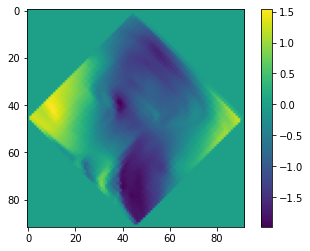

In [49]:
plt.imshow(rot_img[50,0].cpu().data.numpy())
plt.colorbar()

### Test Data for UM

In [2]:
def sample_spherical(npoints, ndim=3):
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    return vec

def uniform_motion(img, unit_vector):
    return img + torch.FloatTensor(unit_vector).repeat(img.shape[0], img.shape[-1]**2).view(img.shape)

In [4]:
direc = "/global/cscratch1/sd/roseyu/Eliza/TF-net/Data/data_64/sample_"
for i in tqdm(range(8000+157, 9870)):
    um_vector = sample_spherical(1, 2)
    img = torch.load(direc + str(i) + ".pt")#+(torch.rand(1, 2, 1, 1)*4-2
    um_img = torch.cat([uniform_motion(img, um_vector) for j in range(img.shape[0])], dim = 0)
    #break
    torch.save(um_img, "/global/cscratch1/sd/roseyu/Eliza/TF-net/Data/um_64/sample_" + str(i) + ".pt")

KeyboardInterrupt: 

torch.Size([64, 64])


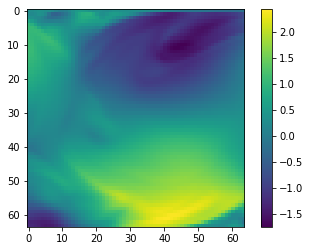

In [5]:
print(um_img[50,0].shape)
plt.imshow(um_img[50,0].cpu().data.numpy())
plt.colorbar()

### Test Data for Rot + UM

In [10]:
direc = "/global/cscratch1/sd/roseyu/Eliza/TF-net/Data/rot_64/sample_"
for i in tqdm(range(8000+164, 9870)):
    um_vector = sample_spherical(1, 2)
    img = torch.load(direc + str(i) + ".pt")#+(torch.rand(1, 2, 1, 1)*4-2
    rot_um_img = torch.cat([uniform_motion(img, um_vector) for j in range(img.shape[0])], dim = 0)
    #break
    torch.save(rot_um_img, "/global/cscratch1/sd/roseyu/Eliza/TF-net/Data/rot_um_64/sample_" + str(i) + ".pt")

KeyboardInterrupt: 

torch.Size([80, 80])


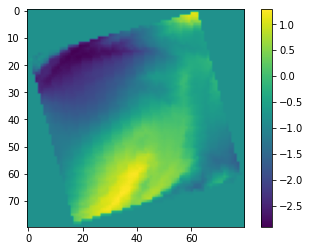

In [9]:
print(rot_um_img[50,0].shape)
plt.imshow(rot_um_img[50,0].cpu().data.numpy())
plt.colorbar()

### Data For DHPM

In [2]:
# Data For DHPM
nc = Dataset('/project/projectdirs/dasrepo/mustafa/datasets/Rayleigh_Benard/result_rb_2d__Ra_2.5e8__Pr_0.71__maxMach_0.1__t_D_max_diffusive_scaling__0.4.nc')
ux_data = nc['u_x']
uy_data = nc['u_y']
raw_ux = ux_data[10000:11500]
raw_uy = uy_data[10000:11500]

w = []
for i in range(1500):
    x = raw_ux[i].filled()
    y = raw_uy[i].filled()
    temp = np.array([x,y])
    w.append(temp) 
    
w = np.array(w)
idx = np.array(range(0,1792,4))
idy = np.array(range(0,256,4))
w = w[:,:,idy][:,:,:,idx]

std = 4522.7046
avg = 1.0424337
w = (w - avg)/std

In [3]:
#0.00195312*4*
#*1.6919324e-05
data_w = np.zeros((2, 1500, 64*448, 4))
data_b = [[],[]]
for d in range(2):
    for t in range(w.shape[0]):   
        for i in range(64):
            for j in range(448):
                data_w[d, t, i*448+j] = np.array([i,j,t,w[t, d, i, j]])
                if t >= 1100:
                    if i == 0 or j == 0 or i == 63 or j == 447 or t == 1100 or t == 1499:                        
                        data_b[d].append([i,j,t,w[t, d, i, j]])
data_b = np.array(data_b)                
#data_w[:,:,:,-2] = (data_w[:,:,:,-2] - np.min(data_w[:,:,:,-2]))/(np.max(data_w[:,:,:,-2])-np.min(data_w[:,:,:,-2]))
#data_w[:,:,:,-3] = (data_w[:,:,:,-3] - np.min(data_w[:,:,:,-3]))/(np.max(data_w[:,:,:,-3])-np.min(data_w[:,:,:,-3]))
#data_w[:,:,:,-4] = (data_w[:,:,:,-4] - np.min(data_w[:,:,:,-4]))/(np.max(data_w[:,:,:,-4])-np.min(data_w[:,:,:,-4]))

In [4]:
train_points = torch.FloatTensor(data_w[:,:1100].reshape(2,1100*28672,4))
torch.save(train_points, "train_points2.pt")
test_points = torch.FloatTensor(data_w[:,1100:].reshape(2,400*28672,4))
torch.save(test_points, "test_points2.pt")
bd_points = torch.FloatTensor(data_b[:,1100:])
torch.save(test_points, "bd_points2.pt")

### 64 * 64

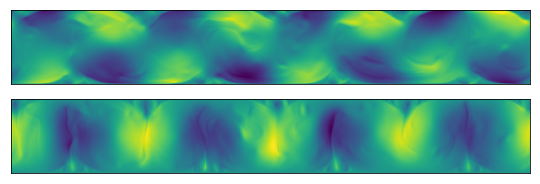

In [19]:
#Snapshot
u = ux_data[1000].filled()
v = uy_data[1000].filled()
fig=plt.figure(figsize=(10, 3))
fig.add_subplot(2, 1, 1)
plt.imshow(u)
plt.xticks([])
plt.yticks([])
fig.add_subplot(2, 1, 2)
plt.imshow(v)
plt.xticks([])
plt.yticks([])
plt.savefig("snapshots_uv.png", dpi = 400)

In [2]:
nc = Dataset('/project/projectdirs/dasrepo/mustafa/datasets/Rayleigh_Benard/result_rb_2d__Ra_2.5e8__Pr_0.71__maxMach_0.1__t_D_max_diffusive_scaling__0.4.nc')
#/project/projectdirs/dasrepo/mustafa/data/result_rb_2d__Ra_2.5e8__Pr_0.71__maxMach_0.1__t_D_max_diffusive_scaling__0.4.nc
ux_data = nc['u_x']
uy_data = nc['u_y']
raw_ux = ux_data[1000:1500]
raw_uy = uy_data[1000:1500]
TB_data = []
for i in range(raw_ux.shape[0]):
    x = np.array([raw_ux[i].filled()[j*64:(j+1)*64,k*64:(k+1)*64] for j in range(4) for k in range(28)])
    y = np.array([raw_uy[i].filled()[j*64:(j+1)*64,k*64:(k+1)*64] for j in range(4) for k in range(28)])
    temp = np.array([x,y])
    TB_data.append(temp) 
#num_subregions * time * channels * w * h
Data = np.float32(np.array(TB_data)).transpose(2,0,1,3,4)
np.save("TB_data_xy.npy", Data)

KeyboardInterrupt: 

In [7]:
#num_subregions * time * w * h
Data = np.load("/global/homes/r/rwang2/Turbulence Data/TB_data_xy.npy")

In [5]:
# Dimensionless
length = 90
Nt = 1/nc['time'][1].filled() 
Ny = 256
scale = Ny/Nt
#0.026/64
seqs = []
for j in range(100, 170, 1):
    for i in range(Data.shape[0]):
        seqs.append(Data[i, j -30 : j + 60])
    
#del Data
seqs = np.array(seqs)
train_seqs = torch.FloatTensor(seqs*scale)
torch.save(train_seqs, "train_seqs.pt")
del train_seqs

seqs = []
for j in range(170, 190, 1):
    for i in range(Data.shape[0]):
        seqs.append(Data[i, j -30 : j + 60])
#del Data
seqs = np.array(seqs)
test_seqs = torch.FloatTensor(seqs*scale)
torch.save(test_seqs, "test_seqs.pt")

In [8]:
# standarization
length = 90
seqs = []
for j in range(100, 170, 1):
    for i in range(Data.shape[0]):
        seqs.append(Data[i, j -30 : j + 60])
#del Data
seqs = np.array(seqs)
avg = 6.3198566
stds = 4486.206
train_seqs = torch.FloatTensor((seqs - avg)/stds)
torch.save(train_seqs, "/global/cscratch1/sd/rwang2/Data/train_seqs.pt")
del train_seqs

seqs = []
for j in range(170, 190, 1):
    for i in range(Data.shape[0]):
        seqs.append(Data[i, j -30 : j + 60])
#del Data
seqs = np.array(seqs)
avg = 6.3198566
stds = 4486.206
test_seqs = torch.FloatTensor((seqs - avg)/stds)
torch.save(test_seqs, "/global/cscratch1/sd/rwang2/Data/test_seqs.pt")

In [4]:
# data for DHPM
data = Data.transpose(1,2,0,3,4)[70:250]
w = np.zeros((180, 2, 256, 1792))
for i in range(28):
    for j in range(4):
        w[:,:, j*64:(j+1)*64, i*64:(i+1)*64] = data[:, :, j*28 + i]
data_w = np.zeros((2, 180, 256*1792, 4))
for d in range(2):
    for t in range(w.shape[0]):   
        for i in range(256):
            for j in range(1792):
                data_w[d, t, i*1792+j] = np.array([0.00195312*4*i,0.00195312*4*j,t,w[t, d, i, j]])
avg = 6.3198566
stds = 4486.206
data_w[:,:,:,-1] = (data_w[:,:,:,-1] - avg)/stds
#data_w[:,:,:,-2] = (data_w[:,:,:,-2] - np.mean(data_w[:,:,:,-2]))/np.std(data_w[:,:,:,-2])
#data_w[:,:,:,-3] = (data_w[:,:,:,-3] - np.mean(data_w[:,:,:,-3]))/np.std(data_w[:,:,:,-3])
#data_w[:,:,:,-4] = (data_w[:,:,:,-4] - np.mean(data_w[:,:,:,-4]))/np.std(data_w[:,:,:,-4])
train_points = torch.FloatTensor(data_w[:,:100])
torch.save(train_points, "train_points.pt")
test_points = torch.FloatTensor(data_w[:,100:])
torch.save(test_points, "test_points.pt")         

## Rotated Images

In [2]:
import cv2
def rotate_image(mat, angle):
    """
    Rotates an image (angle in degrees) and expands image to avoid cropping
    """

    height, width = mat.shape[:2] # image shape has 3 dimensions
    image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0]) 
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))
    return rotated_mat

ModuleNotFoundError: No module named 'cv2'

In [17]:
from torchvision import transforms
import torchvision.transforms.functional as TF
PIL = transforms.ToPILImage()
TTen = transforms.ToTensor()
from PIL import Image


def normalize(tensor):
    return (tensor - torch.min(tensor))/(torch.max(tensor) - torch.min(tensor))

def rotate(img, degree):
    #img shape 2*128*128
    #2*2 2*1*128*128 -> 2*1*128*128
    theta = torch.tensor(degree/180*np.pi)
    rot_m = torch.tensor([[torch.cos(theta), -torch.sin(theta)], [torch.sin(theta), torch.cos(theta)]])
    img = torch.einsum("ab, bcde -> acde",(rot_m, img.unsqueeze(1))).squeeze(1)
    mmin = torch.min(img)
    mmax = torch.max(img)
    img = normalize(img).data.numpy()
    x = TTen(TF.rotate(Image.fromarray(np.uint8(img[0]*255)),degree, expand =  True))
    y = TTen(TF.rotate(Image.fromarray(np.uint8(img[1]*255)),degree, expand =  True))
    rot_img = torch.cat([x, y], dim = 0)
    rot_img[rot_img!=0] = normalize(rot_img[rot_img!=0])
    rot_img[rot_img!=0] = rot_img[rot_img!=0]*(mmax - mmin) + mmin
    return rot_img

In [19]:
direc = "/global/cscratch1/sd/roseyu/Eliza/TF-net/Data/data_64/sample_"
for i in range(7000, 8000):
    degree = (15*(i-7000))%360
    img = torch.load(direc + str(i) + ".pt")#+(torch.rand(1, 2, 1, 1)*4-2)
    rot_img = torch.cat([rotate(img[j], degree).unsqueeze(0) for j in range(img.shape[0])], dim = 0)
    #break
    torch.save(rot_img, "/global/cscratch1/sd/roseyu/Eliza/TF-net/Data/rot2_64/sample_" + str(i) + ".pt")

TypeError: function takes exactly 1 argument (3 given)

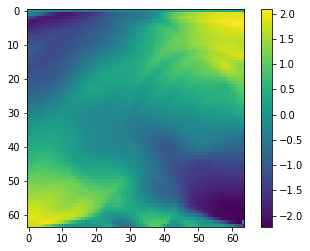

In [16]:
plt.imshow(rot_img[50,0].cpu().data.numpy())
plt.colorbar()

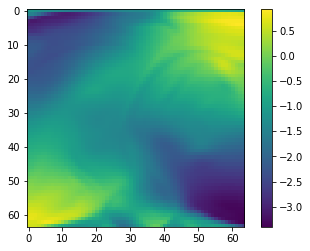

In [47]:
plt.imshow(img[50,0].cpu().data.numpy())
plt.colorbar()